In [67]:
# !pip install matplotlib


In [1]:
from osgeo import gdal
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import re

In [2]:
def pad_number(match):
    number = int(match.group(1))
    return format(number, "02d")

fixed_text = re.sub(r"^(\d+)", pad_number, "1")
fixed_text

'01'

### Get rectangle side length function

In [3]:
def get_scale_in_degrees_and_rect_side_in_px(seconds_cnt):
    # constants
    min_scale = 3
    default_pixel_num = 1200
    overlap_pixel_num = 1
    
    scale_in_degrees = seconds_cnt / min_scale
    rect_side = default_pixel_num * scale_in_degrees
    
    return (scale_in_degrees, rect_side)

In [4]:
get_scale_in_degrees_and_rect_side_in_px(6)

(2.0, 2400.0)

### Function takes big 2D array and returns smaller 2D array in according to passed sizes

In [5]:
# The function takes big 2D array and returns smaller 2D array in according to passed sizes
# If the function can't satisfy passed sizes of array, it returns array with less sizes
def get_2D_array_from_bigger_2D_array(init_arr, left_border, top_border,
                                        tile_size, overlap):
    
    bottom_border = len(init_arr)
    if(bottom_border - top_border > tile_size + overlap):
        bottom_border =  top_border + tile_size + overlap
    right_border = len(init_arr)
    if(right_border - left_border > tile_size + overlap):
        right_border = left_border + tile_size + overlap
        
    res_arr = []
    for i in range(bottom_border - top_border):
        res_arr += [init_arr[i + top_border, left_border : right_border]]
            
    return res_arr
        

### Function returns 2D array combined by equal axis from two 2D arrays

In [6]:
def combine_two_2d_arrays_by_equal_axis(first_arr, second_arr):
    if(first_arr.shape[0] == second_arr.shape[0]):
        return np.hstack((first_arr, second_arr))
    if(first_arr.shape[1] == second_arr.shape[1]):
        return np.vstack((first_arr, second_arr))

In [7]:
def get_2d_index_by_element_number(ncols, number):
    element_row = 0
    element_col = 0
    
    while number > ncols:
        number -= ncols
        element_row += 1
    
    element_col = number - 1
    
    return (element_row, element_col)

In [8]:
math.ceil(0.1)

1

### The function takes four elevation arrays (rectangles) and split top left one in tails with defined size

In [9]:
def split_rect_in_defined_tails(rects, tail_size, left_border, top_border, overlap):
    # Combine all rects to one entire rect
    two_top_combined_rects = np.hstack((rects[0], rects[1]))
    two_bottom_combined_rects = np.hstack((rects[2], rects[3]))
    entire_combined_rect = np.vstack((two_top_combined_rects, two_bottom_combined_rects))
    
    # Getting size of default rect (6000 px)
    rect_side_size = rects[0].shape[0]
    
    free_h_space = rect_side_size - left_border
    free_v_space = rect_side_size - top_border

    tails_cnt_in_h_axis = math.ceil(free_h_space / tail_size)
    
    right_shift = tails_cnt_in_h_axis * tail_size - free_h_space
    bottom_shift = tails_cnt_in_h_axis * tail_size - free_v_space
    
    res_tails = []
            
    for i in range(tails_cnt_in_h_axis):
        for j in range(tails_cnt_in_h_axis):
            res_tails += [get_2D_array_from_bigger_2D_array(entire_combined_rect, left_border + tail_size * j, 
                                                             top_border + tail_size * i, tail_size, overlap)]
#             print(left_border + tail_size * j, top_border + tail_size * i)
        
    return (res_tails, right_shift, bottom_shift)

### The function calculates georeferencing data for tiles

In [10]:
def get_georeferencing_data(scale_in_deg, img_array, long_top_left, lat_top_left, long_delta, lat_delta, ncols, count):
    
    # get width and height of image array
    n_img_rows, n_img_cols = img_array.shape

    # The shift is one tile side length in degrees. It's should be float value
    shift = scale_in_deg

    img_row, img_col = get_2d_index_by_element_number(ncols, count)
    
    long_min_shifted = round(long_top_left + shift * img_col)
    lat_max_shifted = round(lat_top_left - shift * img_row)
    long_max_shifted = round(long_min_shifted + (long_delta * n_img_cols))
    lat_min_shifted = round(lat_max_shifted - (abs(lat_delta) * n_img_rows))
    
    return (long_min_shifted, lat_max_shifted, long_max_shifted, lat_min_shifted)

### The function rounds an one dim array 

In [11]:
def round_one_dim_array_to_default_scale(init_arr, init_arr_scale_in_deg):
    rounded_arr = []
    init_arr_length = len(init_arr)
    
    for i in range(0, init_arr_length - 1, int(init_arr_scale_in_deg)):
        average = 0
        for j in range(i, i + int(init_arr_scale_in_deg)):
            average += init_arr[j]
        average /= int(init_arr_scale_in_deg)
        rounded_arr.append(average)
    
    return rounded_arr

### The function rounds an 2D array values in order to set the array scale to min tile scale

In [12]:
def round_2D_array_to_default_scale(init_arr, init_arr_scale_in_deg):
    rounded_arr = []
    init_arr_side = np.shape(init_arr)[0]
    
    # rows (vertical direction)
    for i in range(0, init_arr_side - 1, int(init_arr_scale_in_deg)): 
        temp_arr = []
        #cols (horizontal direction)
        for j in range(0, init_arr_side - 1, int(init_arr_scale_in_deg)): 
            average = 0 
            for inner_i in range(i, i + int(init_arr_scale_in_deg)): 
                for inner_j in range(j, j + int(init_arr_scale_in_deg)):
                    average += init_arr[inner_i][inner_j]
            average /= int(init_arr_scale_in_deg) ** 2
            temp_arr.append(average)
        temp_arr.append(init_arr[i][init_arr_side - 1])
#         print(temp_arr[10:100])
        rounded_arr += [temp_arr]
    last_rounded_row = round_one_dim_array_to_default_scale(init_arr[init_arr_side - 1], init_arr_scale_in_deg)
    last_rounded_row.append(init_arr[init_arr_side - 1][init_arr_side - 1])
#     print("***", np.shape(last_rounded_row))
    rounded_arr += [last_rounded_row]
#     print("****", np.shape(rounded_arr))
    
    return np.asarray(rounded_arr)

In [13]:
list1 = [1,2,3,4,5]
list2 = [6,7,8,9,0]

list3 = []
list3 += [list1]
list3 += [list2]

np.shape(list3)


(2, 5)

### The function displays data with grid of plots

In [33]:
def plot_image_grid(images, gdal_current_ds, right_shift, bottom_shift, scale_in_deg, res_dict, cmap='gist_earth'):    
    '''Plot a grid of images'''
#     if not ncols:
#         factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
#         ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
#     nrows = int(len(images) / ncols) + int(len(images) % ncols)
    ncols = int(math.sqrt(np.shape(images)[0]))
    nrows = ncols
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()[:len(imgs)]
    
    count = 1
    default_scale_in_deg = 5
    default_scale_in_px = 1200
    long_min, long_delta, dxdy, lat_max, dydx, lat_delta = gdal_current_ds.GetGeoTransform()

    long_top_left = long_min + (right_shift / default_scale_in_px) # !!! не всегда
    lat_top_left = lat_max #- (bottom_shift / default_scale_in_px)

    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
                
            ax.title.set_text(count)
            long_min_shifted, lat_max_shifted, long_max_shifted, lat_min_shifted = get_georeferencing_data(
                                                scale_in_deg, img, long_top_left, lat_top_left, 
                                                long_delta, lat_delta, ncols, count)
            
            # Here I need to round img if it has scale more than min scale (1 deg)
            if(int(scale_in_deg) > 1):
                img = round_2D_array_to_default_scale(img, scale_in_deg)
                
#             print("*", img.shape)
            ax.imshow(img, cmap=cmap, extent=[long_min_shifted, long_max_shifted, lat_min_shifted, lat_max_shifted])
            count += 1

            res_dict[(long_min_shifted, long_max_shifted, lat_min_shifted, lat_max_shifted)] = img
            

## Start of execution

In [15]:
gdal.UseExceptions()

def pad_number(match):
    number = int(match.group(1))
    return format(number, "02d")

gdal_ds = []
srtm_tail_h_cnt = 72
srtm_tail_v_cnt = 24

# for v in range(1, srtm_tail_v_cnt + 1):
#     ds_sub_list = []
#     for h in range(1, srtm_tail_h_cnt + 1):
#         v_num = re.sub(r"^(\d+)", pad_number, str(v))
#         h_num = re.sub(r"^(\d+)", pad_number, str(h))
        
#         path_to_dir = './' + h_num + '_' + v_num
#         path_to_file = path_to_dir + '/srtm_' + h_num + '_' + v_num + '.tif'
        
#         if(os.path.isdir(path_to_dir)):
#             if(os.path.isfile(path_to_file)):
#                 ds_sub_list.append(gdal.Open(path_to_file))
                
#     gdal_ds += [ds_sub_list]
    
# print(gdal_ds)

ds1 = gdal.Open('./41_01/srtm_41_01.tif')
ds2 = gdal.Open('./42_01/srtm_42_01.tif')
ds3 = gdal.Open('./43_01/srtm_43_01.tif')
ds4 = gdal.Open('./41_02/srtm_41_02.tif')
ds5 = gdal.Open('./42_02/srtm_42_02.tif')
ds6 = gdal.Open('./43_02/srtm_43_02.tif')

gdal_ds = [[ds1, ds2, ds3], [ds4, ds5, ds6]]

print(gdal_ds[0][0].GetGeoTransform())

elevations_list = [[], []]

for i in range(len(gdal_ds[0])):
    band1 = gdal_ds[0][i].GetRasterBand(1)
    band2 = gdal_ds[1][i].GetRasterBand(1)
    elevations_list[0] += [band1.ReadAsArray()]
    elevations_list[1] += [band2.ReadAsArray()]

elev_arr = np.asarray(elevations_list)
    
# print(elev_arr)
# print(np.shape(elev_arr))
# len(elev_arr)

(20.0, 0.0008333333333333334, 0.0, 60.0, 0.0, -0.0008333333333333334)


* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
* (1201, 1201)
(20, 21, 59, 60) (1201, 1201)
(21, 22, 59, 60) (1201, 1201)
(22, 23, 59, 60) (1201, 1201)
(23, 24, 59, 60) (1201, 1201)
(24, 25, 59, 60) (1201, 1201)
(20, 21, 58, 59) (1201, 1201)
(21, 22, 58, 59) (1201, 1201)
(22, 23, 58, 59) (1201, 1201)
(23, 24, 5

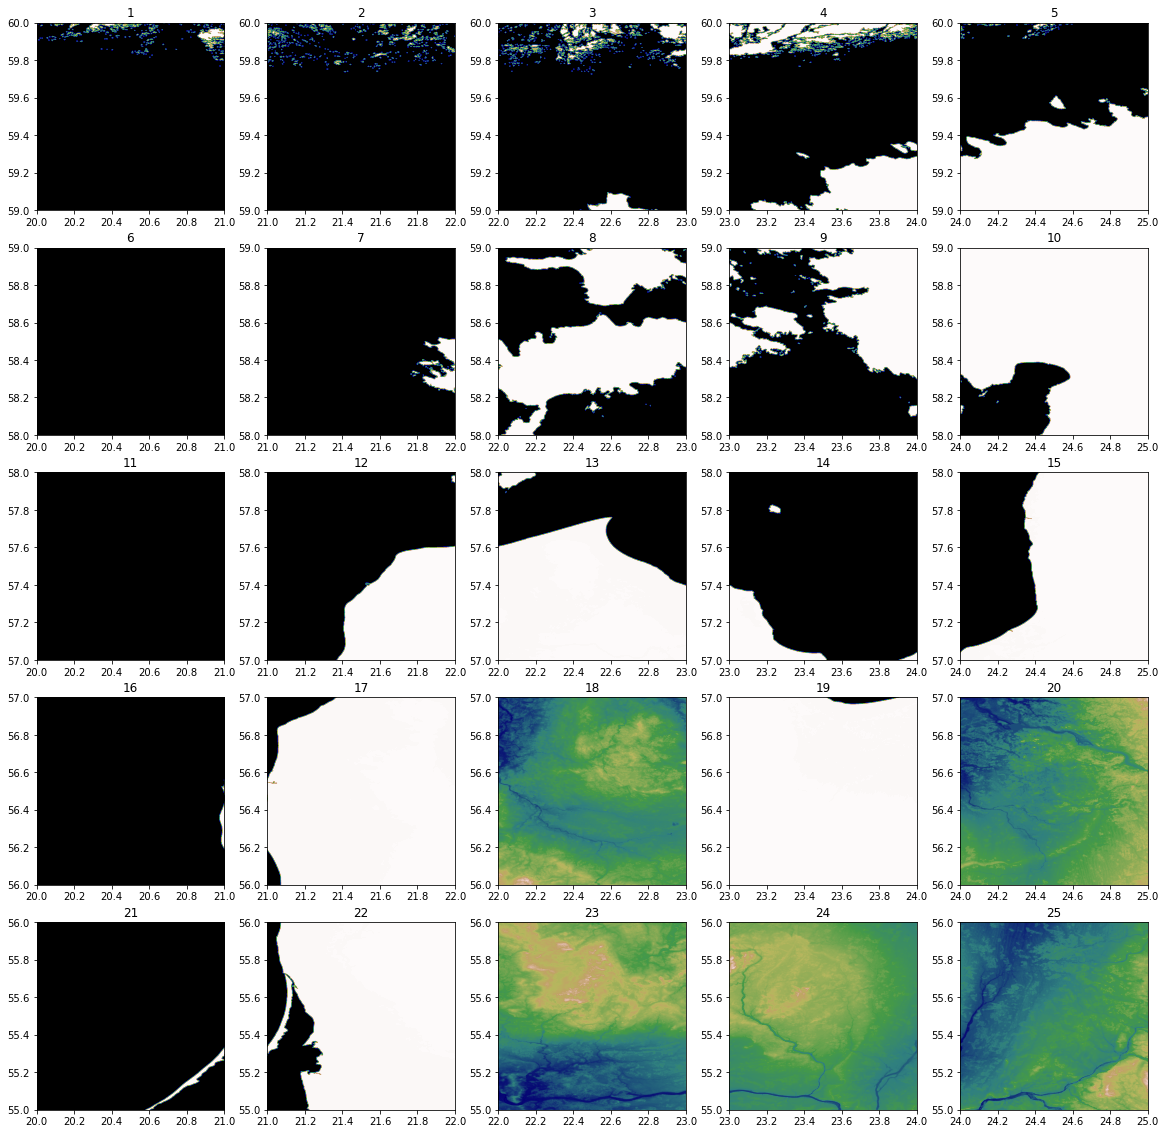

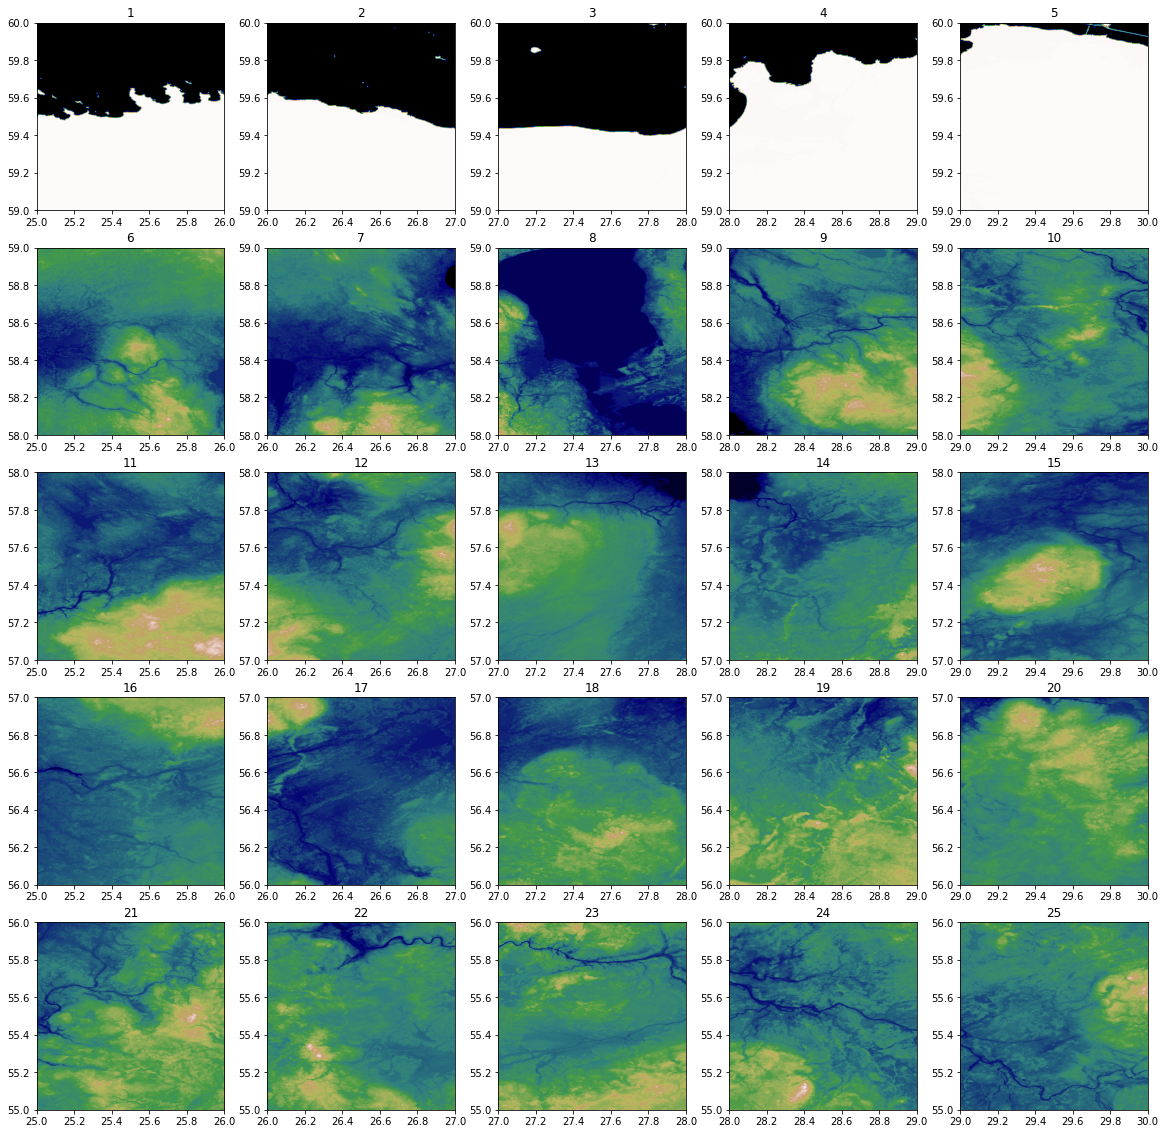

In [34]:
seconds_cnt = 3
scale_in_deg, rect_side_in_px = get_scale_in_degrees_and_rect_side_in_px(seconds_cnt)

res_dict = {}
rects = [[], [], [], []]

prev_right_shift = 0
prev_bottom_shift = 0

for i in range(len(elev_arr[0]) - 1):
    rects[0] = elev_arr[0][i]
    rects[1] = elev_arr[0][i + 1]
    rects[2] = elev_arr[1][i]
    rects[3] = elev_arr[1][i + 1]
    
    tails, right_shift, bottom_shift = split_rect_in_defined_tails(rects, int(rect_side_in_px), 
                                                                   prev_right_shift, prev_bottom_shift, 1)

#     temp(np.array(tails), gdal_ds[0][i], prev_right_shift, prev_bottom_shift, scale_in_deg, res_dict)
    plot_image_grid(np.array(tails), gdal_ds[0][i], prev_right_shift, prev_bottom_shift, scale_in_deg, res_dict)
    prev_right_shift = right_shift
    prev_bottom_shift = bottom_shift

for key, value in res_dict.items():
    print(key, np.shape(value))
    


### Writing to a .bin file

In [31]:
f = open('./res/myfile2.bin', 'wb')


# 2.3. The loop of matrix traversal
for row in res_dict[(29, 30, 55, 56)]:
    # here you just need to write lines with the character '\n'
    for item in row:
        item = str(item) + '\n'
        bt = item.encode() # str=>bytes
        f.write(bt) # write bt to file

# 2.3. Close file
f.close();

### Reading a .bin file

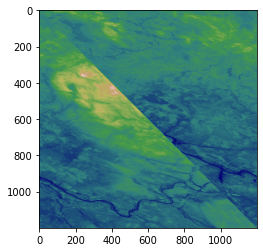

In [32]:
# 3.1. Open file for reading
f = open('./res/myfile2.bin', 'rb')

# 3.2. A new matrix
out_img = []

# 3.3.2. Loop of reading the lines and the creation of a matrix size m2*n2
i = 0
while i < 1200: # m2 rows in matrix
    row = [] # one row in list
    j = 0
    while j < 1200:
        bs = f.readline() # read one element of type bytes
        s = bs.decode() # convert bytes=>str
        s = s[:-1] # remove '\n'
        num = float(s)
        row += [num] # add to the list
        j = j + 1
    out_img += [row] # add one row of the list to the matrix
    i = i + 1

# i = 0
# while i < 100:
#     print("out_img[", i, "] = ", out_img[i])
#     i = i + 1
    
plt.imshow(out_img, cmap='gist_earth')
plt.show()